In [1]:
import config
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
from urllib.request import urlopen
import ast
import datetime
import os
import altair as alt
import math
import time
pd.set_option('display.max_colwidth', None)
pd.options.mode.copy_on_write = True

In [2]:
API_KEY = config.api_key
current_directory = os.getcwd()
main_dir = os.path.dirname(current_directory)
data = os.path.join(os.path.dirname(current_directory), "data")
images = os.path.join(os.path.dirname(current_directory), "images")
htmls = os.path.join(os.path.dirname(current_directory), "htmls")
screenshots = os.path.join(os.path.dirname(current_directory), "screenshots")

### Now we need to find all bills during the time studied as well their respective sponsors and co-sponsors

1) We will find the (i) sponsored legislation and (ii) co-sponsored legislation of each member in the super-senate

2) We will keep bills introduced only during the time span studied: 2011-2021 (112th-116th congress)

In [3]:
super_senate = pd.read_csv(data + "//super_senate.csv")
super_senate.head(3)

,bioguideId,name,terms,state,party,birthYear,sponsoredLegislation_count,sponsoredLegislation_url,cosponsoredLegislation_count,cosponsoredLegislation_url,years_house,years_senate
0,C001098,"Cruz, Ted","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}",Texas,Republican,1970,773.0,https://api.congress.gov/v3/member/C001098/sponsored-legislation,1579,https://api.congress.gov/v3/member/C001098/cosponsored-legislation,0,11
1,W000817,"Warren, Elizabeth","{'item': [{'chamber': 'Senate', 'startYear': 2013}]}",Massachusetts,Democratic,1949,569.0,https://api.congress.gov/v3/member/W000817/sponsored-legislation,3457,https://api.congress.gov/v3/member/W000817/cosponsored-legislation,0,11
2,W000802,"Whitehouse, Sheldon","{'item': [{'chamber': 'Senate', 'startYear': 2007}]}",Rhode Island,Democratic,1955,564.0,https://api.congress.gov/v3/member/W000802/sponsored-legislation,4062,https://api.congress.gov/v3/member/W000802/cosponsored-legislation,0,17


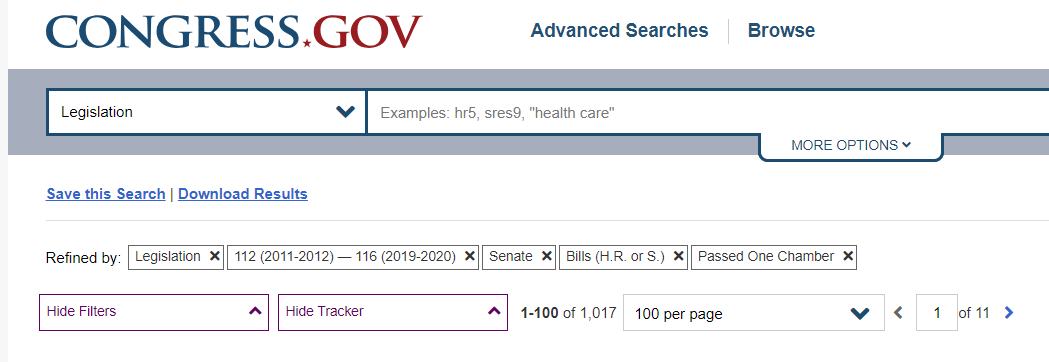

In [4]:
from IPython.display import Image, display

# Replace the file path with the correct one if needed
file_path = screenshots + '//Screenshot_1.png'

# Display the image
display(Image(filename=file_path))